In [162]:
# for reloading the editable module
%load_ext autoreload
%autoreload 2

# Register your package and submodules
# %aimport probabilistic_load_forecast
# %aimport probabilistic_load_forecast.application.services
# %aimport probabilistic_load_forecast.adapters.db
# %aimport probabilistic_load_forecast.adapters.cds
# %aimport probabilistic_load_forecast.adapters.entsoe
# %aimport probabilistic_load_forecast.domain.model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
from pathlib import Path
from dotenv import load_dotenv
from datetime import timezone, datetime
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [164]:
# Import services and domain models
from probabilistic_load_forecast.application.services import (
    GetActualLoadData,
    GetERA5DataFromDB,
    GetERA5DataFromCDSStore,
    CreateCDSCountryAverages
) 

from probabilistic_load_forecast.domain.model import LoadMeasurement, LoadTimeseries, Era5Timeseries

# Import adapters for data access
from probabilistic_load_forecast.adapters.db import (
    EntsoePostgreRepository,
    Era5PostgreRepository
)

from probabilistic_load_forecast.adapters.entsoe import (
    EntsoeAPIClient,
    EntsoeFetcher,
    XmlLoadMapper,
    EntsoeDataProvider
)

from probabilistic_load_forecast.adapters.cds import (
    CDSAPIClient,
    CDSConfig,
    CDSDataProvider
)

# Import configuration
from probabilistic_load_forecast import config

# Load environment variables

if not load_dotenv(Path("../..") / ".env"):
    raise FileNotFoundError("Could not open the .env file.")

In [165]:
# Initialize database repositories
try:
    # Load data repository
    load_repo = EntsoePostgreRepository(config.get_postgre_uri())
    
    # ERA5 weather data repository
    era5_repo = Era5PostgreRepository(config.get_postgre_uri())
    
    print("Database repositories initialized successfully")
except Exception as e:
    print(f"Error initializing repositories: {e}")
    print("Make sure your .env file contains the correct database credentials")

Database repositories initialized successfully


In [166]:
# Initialize services
get_load_data = GetActualLoadData(load_repo)
get_era5_data = GetERA5DataFromDB(era5_repo)

print("Services initialized successfully")

Services initialized successfully


In [167]:
start = datetime(2018, 10, 1, 0, 0, tzinfo=timezone.utc)
end = datetime(2025, 10, 11, 0, 0, tzinfo=timezone.utc)
era5_data = get_era5_data(variables=["t2m", "u10", "v10", "ssrd", "tp"], country_code="AT", start=start, end=end)
actual_load_ts = get_load_data(start, end)

# Amalysis of the Actual Load Data

In [168]:
actual_load_ts.data.describe()

,actual_load_mw
count,246432.000000
mean,6931.961162
std,1341.643406
min,4009.000000
25%,5858.000000
50%,6874.000000
75%,7883.000000
max,10818.000000


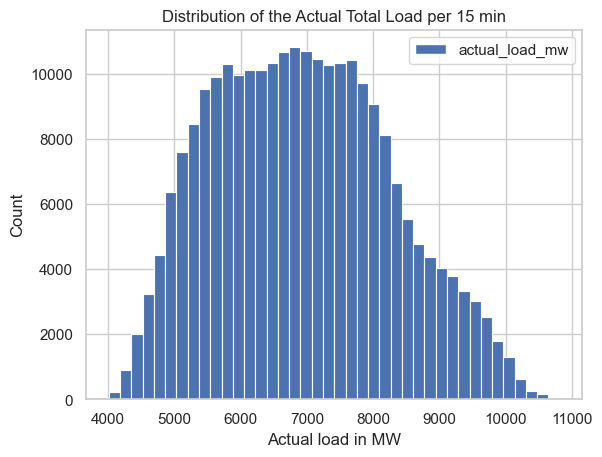

In [206]:
ax = sns.histplot(
    data=actual_load_ts.data,
    alpha=1.0,
    bins=40
)
ax.set_title("Distribution of the Actual Total Load per 15 min")
ax.set_xlabel("Actual load in MW");

The overall shape of the distribution seems approximately symmetric arount the mean of ~7000 MW per 15 min. The most values cluster between 6000 and 8000 MW.

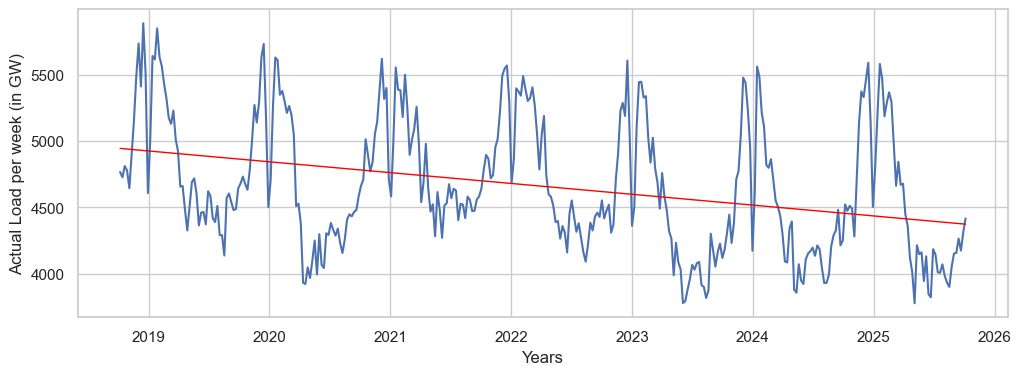

In [300]:
temp_df = actual_load_ts.data.reset_index()
temp_df["period"] = temp_df["period"].dt.to_timestamp()
temp_df = temp_df.resample("W", on="period").sum().reset_index()
temp_df.drop(index=temp_df.index[-1], inplace=True)

temp_df_gw = temp_df.copy()
temp_df_gw["actual_load_gw"] = temp_df["actual_load_mw"] / 1000
plt.figure(figsize=(12, 4))

ax = sns.lineplot(
    data=temp_df_gw,
    x="period",
    y="actual_load_gw",
);

ax.set_ylabel("Actual Load per week (in GW)");
ax.set_xlabel("Years");

import numpy as np
x = np.arange(len(temp_df_gw))
y = temp_df_gw["actual_load_gw"]
trend = np.polyval(np.polyfit(x, y, 1), x)
ax.plot(temp_df_gw["period"], trend, color="red", lw=1, label="Trendline")

# Analysis of the Temperature at 2 meters

Description: 
	
Temperature of air at 2m above the surface of land, sea or in-land waters. 2m temperature is calculated by interpolating between the lowest model level and the Earth's surface, taking account of the atmospheric conditions. Temperature measured in kelvin can be converted to degrees Celsius (°C) by subtracting 273.15.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview


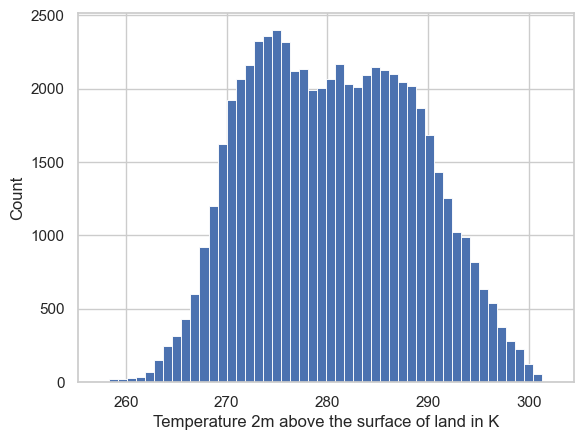

In [170]:
ax = sns.histplot(
    data=era5_data["t2m"],
    legend=False,
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Temperature 2m above the surface of land in K");

# Analysis of the Solar Radiation Downwards

Description: 

	
Amount of solar radiation (also known as shortwave radiation) reaching the surface of the Earth. This variable comprises both direct and diffuse solar radiation. Radiation from the Sun (solar, or shortwave, radiation) is partly reflected back to space by clouds and particles in the atmosphere (aerosols) and some of it is absorbed. The rest is incident on the Earth's surface (represented by this variable). To a reasonably good approximation, this variable is the model equivalent of what would be measured by a pyranometer (an instrument used for measuring solar radiation) at the surface. However, care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step. This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units are joules per square metre (J m^-2). To convert to watts per square metre (W m^-2), the accumulated values should be divided by the accumulation period expressed in seconds. The ECMWF convention for vertical fluxes is positive downwards.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

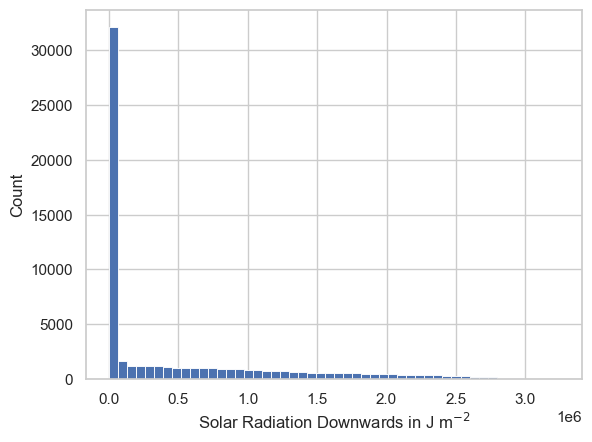

In [171]:
ax = sns.histplot(
    data=era5_data["ssrd"],
    legend=False,
    log_scale=(False, False),
    alpha=1.0,
    bins=50,
)

ax.set_xlabel("Solar Radiation Downwards in J m$^{-2}$");

The distribution seems failry right skewed, indicating that the most hours receive comparably small amounts of solar energy per square meter. 

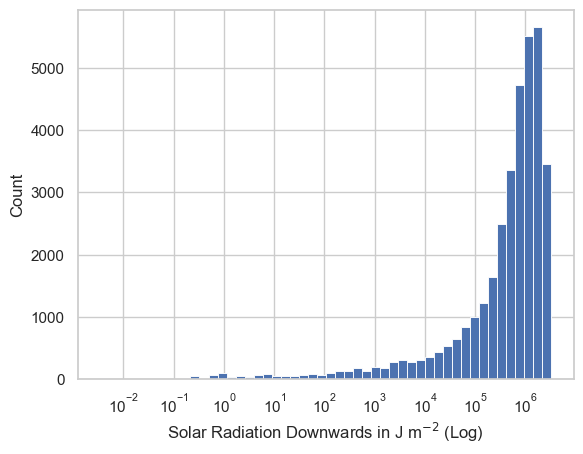

In [172]:
ax = sns.histplot(
    data=era5_data["ssrd"],
    legend=False,
    log_scale=(True, False),
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Solar Radiation Downwards in J m$^{-2}$ (Log)");

After excluding the 0 values one can see that the must values are in the range of $10^{5}$ to $10^{6}$. 

# Analysis of the Total Precipitation

Description:

Accumulated liquid and frozen water, including rain and snow, that falls to the Earth's surface. It is the sum of large-scale precipitation (that precipitation which is generated by large-scale weather patterns, such as troughs and cold fronts) and convective precipitation (generated by convection which occurs when air at lower levels in the atmosphere is warmer and less dense than the air above, so it rises). Precipitation variables do not include fog, dew or the precipitation that evaporates in the atmosphere before it lands at the surface of the Earth. This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units of precipitation are depth in metres. It is the depth the water would have if it were spread evenly over the grid box. Care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

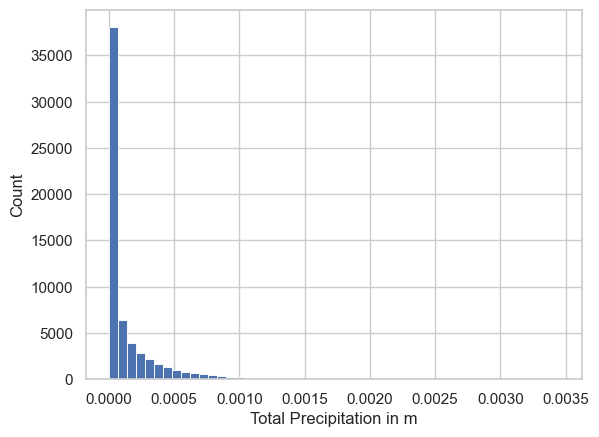

In [173]:
ax = sns.histplot(
    data=era5_data["tp"],
    legend=False,
    log_scale=(False, False),
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Total Precipitation in m");

The must number of hours there seems to be no to little total precipitation.

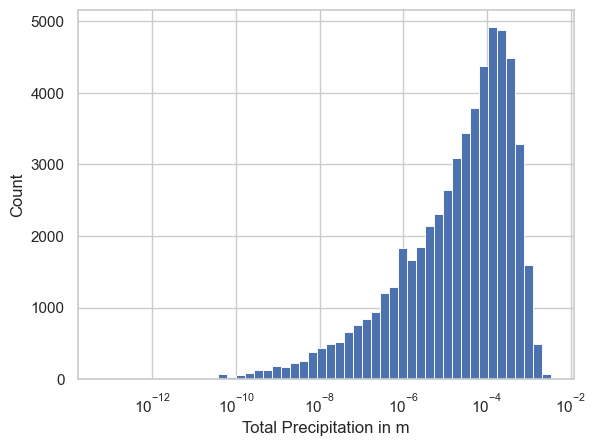

In [174]:
ax = sns.histplot(
    data=era5_data["tp"],
    legend=False,
    log_scale=(True, False),
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Total Precipitation in m");

Plotting the data after excluding 0 values it becomes evident that most of the values are within a range of $10^{-6}$ to $10^{-2}$ eg. are range of 0.001 mm to 10 mm over the total area of austria.

# Analysis of the Zonal wind component

Description:

Eastward component of the 10m wind. It is the horizontal speed of air moving towards the east, at a height of ten metres above the surface of the Earth, in metres per second. Care should be taken when comparing this variable with observations, because wind observations vary on small space and time scales and are affected by the local terrain, vegetation and buildings that are represented only on average in the ECMWF Integrated Forecasting System. This variable can be combined with the V component of 10m wind to give the speed and direction of the horizontal 10m wind.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview

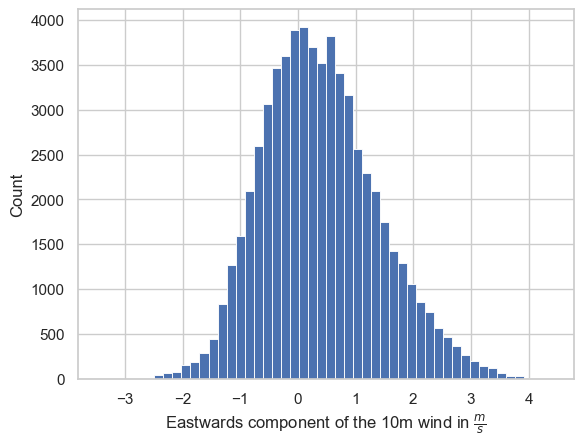

In [175]:
ax = sns.histplot(
    data=era5_data["u10"],
    legend=False,
    log_scale=False,
    alpha=1.0,
    bins=50,
)

ax.set_xlabel("Eastwards component of the 10m wind in $\\frac{m}{s}$");

The overall averaged sum of east-west wind seems to be fairly normal distrubuted in the range of 4 $\frac{m}{s}$ to 3 $\frac{m}{s}$.  

# Analysis of the Meridional wind component

Description:

Northward component of the 10m wind. It is the horizontal speed of air moving towards the north, at a height of ten metres above the surface of the Earth, in metres per second. Care should be taken when comparing this variable with observations, because wind observations vary on small space and time scales and are affected by the local terrain, vegetation and buildings that are represented only on average in the ECMWF Integrated Forecasting System. This variable can be combined with the U component of 10m wind to give the speed and direction of the horizontal 10m wind.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

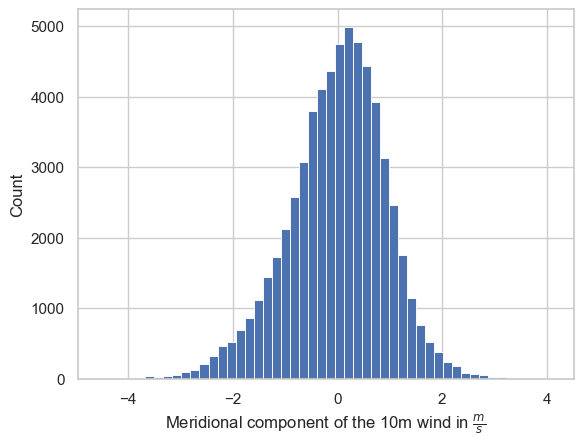

In [176]:
ax = sns.histplot(
    data=era5_data["v10"],
    legend=False,
    log_scale=False,
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Meridional component of the 10m wind in $\\frac{m}{s}$");

The overall country averaged sum of south-north wind seems to be in the same range as the zonal wind component (4 $\frac{m}{s}$ to 3 $\frac{m}{s}$).  

# Multivaraite analysis